<a href="https://colab.research.google.com/github/hublun/Beyond-ChatGPT/blob/main/shap_lime_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.3 MB/s eta 0:00:00


In [2]:
pip install lime --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=bf012c1a6d7e0c86ec24c4bb94c2a2c8e7ec69a7c4a82f2f949d1e05eab82d50
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
import pandas as pd
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import shap
import lime
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# Load the Iris dataset
iris = datasets.load_iris()

In [4]:
# Create a DataFrame for the features (X) and Series for the target variable (y)
X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
y = pd.Series(data=iris.target, name='species')

# Standardize the numerical features for better correlation analysis
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

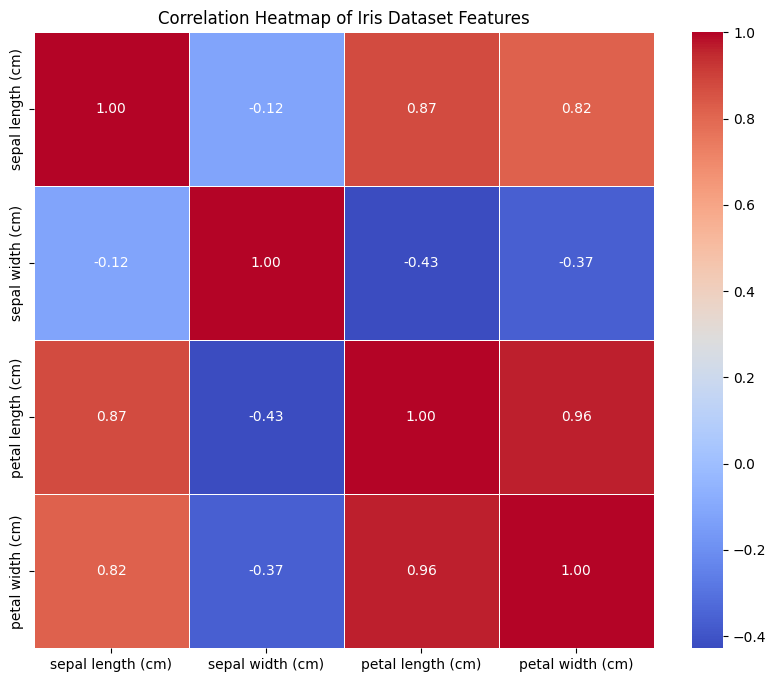

[ 1.         -0.11756978  0.87175378  0.81794113 -0.11756978  1.
 -0.4284401  -0.36612593  0.87175378 -0.4284401   1.          0.96286543
  0.81794113 -0.36612593  0.96286543  1.        ]
Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Row Indices: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Column Indices: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [5]:
# Create a correlation matrix
correlation_matrix = pd.DataFrame(X_standardized, columns=iris.feature_names).corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Iris Dataset Features')
plt.show()

# Correlation_matrix is the DataFrame containing correlation values
correlation_values = correlation_matrix.values

# Convert the correlation matrix values to a flat list
correlation_list = correlation_values.flatten()

# Display or print the correlation values
print(correlation_list)

# Get feature names
feature_names = correlation_matrix.columns.tolist()

# Get row and column indices
row_indices, col_indices = correlation_matrix.index.tolist(), correlation_matrix.columns.tolist()

# Display the extracted information
print("Feature Names:", feature_names)
print("Row Indices:", row_indices)
print("Column Indices:", col_indices)

In [6]:
# Remove highly correlated variables (threshold = 0.8)
threshold = 0.8
high_corr_pairs = [(i, j) for i in range(len(correlation_matrix.columns)) for j in range(i + 1, len(correlation_matrix.columns))
                   if abs(correlation_matrix.iloc[i, j]) > threshold]

# Remove one variable from each highly correlated pair
for i, j in high_corr_pairs:
    print(f"Highly correlated pair: {feature_names[i]} - {feature_names[j]}, Correlation: {correlation_matrix.iloc[i, j]}")

Highly correlated pair: sepal length (cm) - petal length (cm), Correlation: 0.871753775886584
Highly correlated pair: sepal length (cm) - petal width (cm), Correlation: 0.8179411262715761
Highly correlated pair: petal length (cm) - petal width (cm), Correlation: 0.9628654314027962


In [7]:
# Variables to keep based on the analysis
# For simplicity, we keep 'sepal length (cm)' and 'petal length (cm)'
selected_features = ['sepal length (cm)', 'petal length (cm)']

# Subset the data based on the selected features
X_subset = X[selected_features]

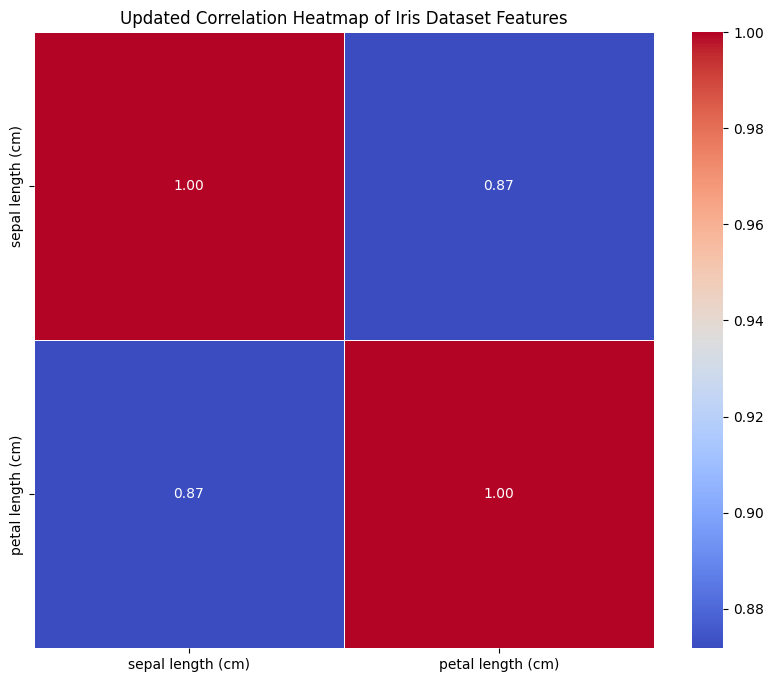

[1.         0.87175378 0.87175378 1.        ]
Updated Feature Names: ['sepal length (cm)', 'petal length (cm)']
Updated Row Indices: ['sepal length (cm)', 'petal length (cm)']
Updated Column Indices: ['sepal length (cm)', 'petal length (cm)']


In [8]:
# Create a correlation matrix for the updated dataset
correlation_matrix_updated = pd.DataFrame(X_subset, columns=selected_features).corr()

# Generate a new heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_updated, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Updated Correlation Heatmap of Iris Dataset Features')
plt.show()

# Correlation_matrix_updated is the DataFrame containing correlation values
correlation_values_updated = correlation_matrix_updated.values

# Convert the updated correlation matrix values to a flat list
correlation_list_updated = correlation_values_updated.flatten()

# Display or print the updated correlation values
print(correlation_list_updated)

# Get feature names for the updated dataset
feature_names_updated = correlation_matrix_updated.columns.tolist()

# Get row and column indices for the updated dataset
row_indices_updated, col_indices_updated = correlation_matrix_updated.index.tolist(), correlation_matrix_updated.columns.tolist()

# Display the extracted information for the updated dataset
print("Updated Feature Names:", feature_names_updated)
print("Updated Row Indices:", row_indices_updated)
print("Updated Column Indices:", col_indices_updated)


In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Create an instance of MLPClassifier
mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.feature_names = iris.feature_names

In [11]:
# Fit the model to the training data
mlp_classifier.fit(X_train, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPClassifier(random_state=42)

In [12]:
# Wrap MLPClassifier inside a function
def model_predict_proba(X):
    return mlp_classifier.predict_proba(X)

print(mlp_classifier.get_params())

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [14]:
# Number of clusters (K) for summarizing the background
K = 10

# We use shap.kmeans to summarize the background
background_summary = shap.kmeans(X_train, K)

# Create SHAP explainer using KernelExplainer with summarized background
shap_explainer = shap.KernelExplainer(mlp_classifier.predict_proba, background_summary)
shap_values = shap_explainer.shap_values(X_test[:100])

# X_test DataFrame
X_test_df = pd.DataFrame(X_test, columns=iris.feature_names)

# Create SHAP force plot for specific instance
shap.force_plot(shap_explainer.expected_value[0], shap_values[0][0, :], X_test_df.iloc[0, :])

# Generate summary plot
#shap.summary_plot(shap_values, X_test_df, feature_names=iris.feature_names)

  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
print(feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [16]:
# X_train DataFrame without named columns
X_train.columns = iris.feature_names

# Explicitly provide feature names
feature_names = iris.feature_names

# Create LIME explainer
explainer_lime_summary = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    discretize_continuous=True
)

# Print the generated LIME explanations
print("Generated LIME Explanations:")
print(lime_explanations_summary)

# Explain the first instance in X_test
lime_exp = explainer_lime_summary.explain_instance(X_test.values[0], model_predict_proba, num_features=len(feature_names))

# Display the explanation
lime_exp.show_in_notebook()

# Extract feature importances and names
feature_importances = lime_exp.as_list()

# Display the summary data
print(feature_importances)

Generated LIME Explanations:


NameError: name 'lime_explanations_summary' is not defined

In [ ]:
# Convert X_test to a NumPy array
X_test_array = X_test.values

In [ ]:
# Select a specific data instance for interpretation
data_instance = X_test.iloc[0, :]


LIME Summary Data:
              Feature  Weight_LIME
0                4.25     0.251770
1                0.30     0.043301
2                5.75     0.042887
3    sepal width (cm)     0.003977
4                1.50     0.192906
5    petal width (cm)     0.093419
6                5.10    -0.037713
7    sepal width (cm)    -0.012854
8   sepal length (cm)     0.134990
9    petal width (cm)    -0.128164
10  petal length (cm)    -0.110363
11               1.30    -0.050572
12               2.80     0.001723
13  petal length (cm)    -0.374265
14               3.00    -0.003574
15  sepal length (cm)    -0.114757




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



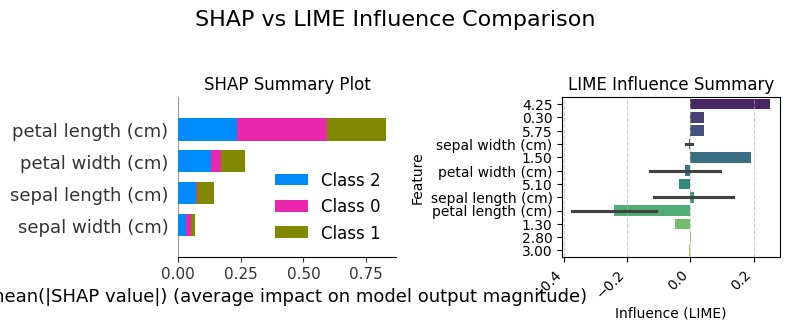

In [ ]:
# Convert LIME explanations to DataFrame
lime_explanations_df = pd.DataFrame(lime_explanations_summary)

# Extract feature names without numerical ranges
extract_feature_name = lambda x: x.split('<')[0].strip() if '<' in x else x.split('>')[0].strip()
lime_explanations_df.columns = [extract_feature_name(col) for col in lime_explanations_df.columns]

# Melt the LIME DataFrame for easier merging
lime_melted = lime_explanations_df.melt(value_vars=list(iris.feature_names), var_name='Feature', value_name='Weight_LIME')

# Group by feature and calculate the mean of LIME weights
lime_summary_data = lime_melted.groupby('Feature')['Weight_LIME'].mean().reset_index()

# Calculate the mean Lime value for each feature
lime_summary_data = lime_explanations_df.mean().reset_index()
lime_summary_data.columns = ['Feature', 'Weight_LIME']

# Print lime_summary_data
print("\nLIME Summary Data:")
print(lime_summary_data)

# Plot summary plots for both SHAP and LIME side-by-side
plt.figure(figsize=(16, 6))

# SHAP summary plot
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values, features=X_test, feature_names=iris.feature_names, show=False)
plt.title('SHAP Summary Plot')

# LIME summary plot
plt.subplot(1, 2, 2)
sns.barplot(x='Weight_LIME', y='Feature', data=lime_summary_data, palette='viridis')
plt.xlabel('Influence (LIME)')
plt.ylabel('Feature')
plt.title('LIME Influence Summary')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Rotate x-axis labels to avoid overlapping
plt.xticks(rotation=45, ha='right')

# Add an overall title
plt.suptitle('SHAP vs LIME Influence Comparison', fontsize=16, y=1.05)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plots
plt.show()